In [1]:
import pandas as pd


In [7]:
#read the csv file
df = pd.read_csv('/content/claims_data(1).csv', dtype={
    'Claim ID': str,
    'Provider ID': str,
    'Patient ID': str,
    'Procedure Code': str,
    'Diagnosis Code': str,
    'Insurance Type': str,
    'Claim Status': str,
    'Reason Code': str,
    'Follow-up Required': str,
    'AR Status': str,
    'Outcome': str
    })

df.head()


,Claim ID,Provider ID,Patient ID,Date of Service,Billed Amount,Procedure Code,Diagnosis Code,Allowed Amount,Paid Amount,Insurance Type,Claim Status,Reason Code,Follow-up Required,AR Status,Outcome
0,0HO1FSN4AP,126528997,7936697103,8/7/2024,304,99231,A02.1,218,203,Self-Pay,Paid,Incorrect billing information,Yes,Pending,Partially Paid
1,9U86CI2P5A,6986719948,1547160031,6/21/2024,348,99213,A16.5,216,206,Medicare,Paid,Pre-existing condition,Yes,Open,Denied
2,1QEU1AIDAU,1355108115,2611585318,7/4/2024,235,99213,A00.1,148,119,Commercial,Under Review,Duplicate claim,No,Denied,Denied
3,WH7XDS8CEO,9991055906,7167948632,5/26/2024,112,99215,A18.6,79,69,Medicare,Denied,Authorization not obtained,No,Partially Paid,Denied
4,M6OJEZ8KGI,7382167012,2140226267,7/16/2024,406,99238,A17.9,320,259,Medicare,Denied,Authorization not obtained,No,On Hold,Denied


In [8]:
#change date of service to date format
df['Date of Service'] = pd.to_datetime(df['Date of Service'], format= '%m/%d/%Y')

#Step 2: Ensure 'Provider ID' and 'Patient ID' are strings and strip any whitespace
df['Provider ID'] = df['Provider ID'].astype(str).str.strip()
df['Patient ID'] = df['Patient ID'].astype(str).str.strip()

# Step 3: Ensure 'Billed Amount', 'Allowed Amount', and 'Paid Amount' are numeric
df['Billed Amount'] = pd.to_numeric(df['Billed Amount'], errors='coerce')
df['Allowed Amount'] = pd.to_numeric(df['Allowed Amount'], errors='coerce')

# Step 4: Standardize text columns (convert to uppercase, strip whitespace)
text_columns = ['Claim ID', 'Procedure Code', 'Diagnosis Code', 'Insurance Type',
                'Claim Status', 'Reason Code', 'Follow-up Required', 'AR Status', 'Outcome']
for col in text_columns:
    df[col] = df[col].str.upper().str.strip()

#check for missing values and handle them with 'unknown'
df.fillna('Unknown', inplace=True)

In [9]:
# Save the cleaned DataFrame to a new CSV file
df.to_csv('cleaned_claims_data.csv', index=False)

In [11]:
#read the cleaned csv
dfCd = pd.read_csv('/content/cleaned_claims_data.csv')
dfCd.head()

,Claim ID,Provider ID,Patient ID,Date of Service,Billed Amount,Procedure Code,Diagnosis Code,Allowed Amount,Paid Amount,Insurance Type,Claim Status,Reason Code,Follow-up Required,AR Status,Outcome
0,0HO1FSN4AP,126528997,7936697103,2024-08-07,304,99231,A02.1,218,203,SELF-PAY,PAID,INCORRECT BILLING INFORMATION,YES,PENDING,PARTIALLY PAID
1,9U86CI2P5A,6986719948,1547160031,2024-06-21,348,99213,A16.5,216,206,MEDICARE,PAID,PRE-EXISTING CONDITION,YES,OPEN,DENIED
2,1QEU1AIDAU,1355108115,2611585318,2024-07-04,235,99213,A00.1,148,119,COMMERCIAL,UNDER REVIEW,DUPLICATE CLAIM,NO,DENIED,DENIED
3,WH7XDS8CEO,9991055906,7167948632,2024-05-26,112,99215,A18.6,79,69,MEDICARE,DENIED,AUTHORIZATION NOT OBTAINED,NO,PARTIALLY PAID,DENIED
4,M6OJEZ8KGI,7382167012,2140226267,2024-07-16,406,99238,A17.9,320,259,MEDICARE,DENIED,AUTHORIZATION NOT OBTAINED,NO,ON HOLD,DENIED


1. Perform Data Quality Assurance (QA)

Before proceeding with analysis, we need to ensure the cleaned data is consistent, accurate, and reliable. This step helps catch any issues that might have been missed during cleaning.

Actions:

    Validate Key Fields:
        Claim ID: Ensure all Claim ID values are unique (since this is likely a primary key).

In [12]:
#Validate Claim ID, check for duplicates since it is a primary Key
if dfCd['Claim ID'].is_unique:
  print("No duplicates found in Claim ID")
else:
  print("Duplicates found in Claim ID")

No duplicates found in Claim ID


Financial Fields: Ensure Paid Amount ≤ Allowed Amount ≤ Billed Amount, as this reflects typical billing logic. Flag any rows where this hierarchy is violated:

In [13]:
#ensure Paid Amount ≤ Allowed Amount ≤ Billed Amount
if (dfCd['Paid Amount'] <= dfCd['Allowed Amount']).all() and (dfCd['Allowed Amount'] <= dfCd['Billed Amount']).all():
  print("Financial fields are consistent")
else:
  print("Financial fields are not consistent")

Financial fields are consistent


Check for Outliers:

    Use summary statistics to identify outliers in numeric fields like Billed Amount, Allowed Amount, and Paid Amount

In [14]:
#check outliers in Billed Amount, Allowed Amount, and Paid Amount
numeric_columns = ['Billed Amount', 'Allowed Amount', 'Paid Amount']
summary_stats = dfCd[numeric_columns].describe()
print(summary_stats)

       Billed Amount  Allowed Amount  Paid Amount
count     1000.00000     1000.000000  1000.000000
mean       297.19100      223.112000   200.754000
std        116.36365       90.784731    83.353688
min        100.00000       64.000000    53.000000
25%        197.00000      147.750000   133.000000
50%        297.00000      225.000000   200.000000
75%        395.00000      289.000000   262.000000
max        500.00000      442.000000   423.000000


Visualize distributions using boxplots to spot anomalies:

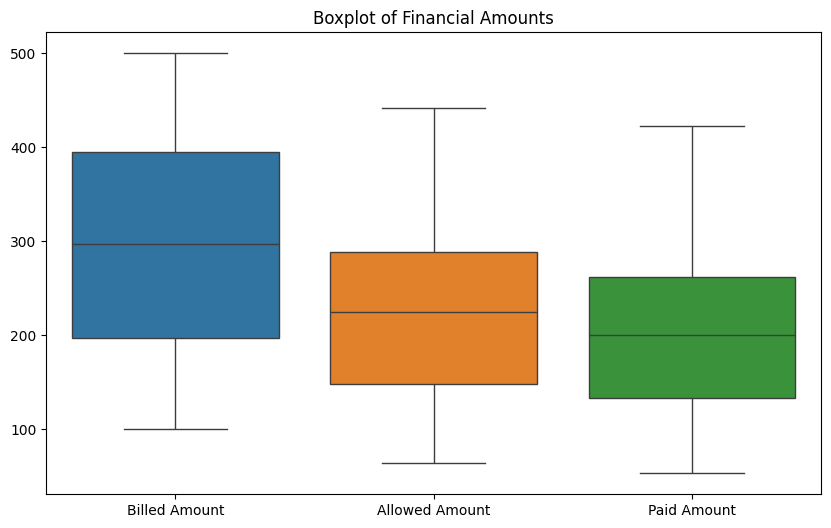

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Billed Amount', 'Allowed Amount', 'Paid Amount']])
plt.title('Boxplot of Financial Amounts')
plt.show()

**Key Observations:**

  **Billed Amount** shows the highest variability, with values ranging from approximately 100 to 500, and a median around 300.

  **Allowed Amount** has a slightly narrower range, spanning from about 65 to 450, with a median near 225.

  **Paid Amount** demonstrates the least variability, with values between 50 and 425, and a median around 200.

All three distributions are relatively symmetric with no visible outliers, indicating consistent patterns in financial processing across these categories. The boxplots reveal that while billed amounts tend to be highest, the paid amounts show the most consistent, with allowed amounts falling between these two in both median value and variability.

Categorical Consistency:

    Check for unexpected values in categorical fields like Insurance Type, Claim Status, Follow-up Required, AR Status, and Outcome

In [16]:
for col in ['Insurance Type', 'Claim Status', 'Follow-up Required', 'AR Status', 'Outcome']:
    print(f"Unique values in {col}:")
    print(df[col].value_counts())
    print("\n")

Unique values in Insurance Type:
Insurance Type
MEDICAID      259
COMMERCIAL    259
SELF-PAY      249
MEDICARE      233
Name: count, dtype: int64


Unique values in Claim Status:
Claim Status
UNDER REVIEW    338
PAID            334
DENIED          328
Name: count, dtype: int64


Unique values in Follow-up Required:
Follow-up Required
YES    522
NO     478
Name: count, dtype: int64


Unique values in AR Status:
AR Status
PARTIALLY PAID    184
ON HOLD           177
PENDING           162
OPEN              160
CLOSED            160
DENIED            157
Name: count, dtype: int64


Unique values in Outcome:
Outcome
PAID              357
DENIED            331
PARTIALLY PAID    312
Name: count, dtype: int64




2. Conduct Exploratory Data Analysis (EDA)

EDA will help us understand the dataset’s structure, uncover patterns, and identify insights that can guide further analysis or business decisions.

In [17]:
#Generate summary statistics for 'Billed Amount', 'Allowed Amount', 'Paid Amount'
summary_stats = dfCd[['Billed Amount', 'Allowed Amount', 'Paid Amount']].describe()
print(summary_stats)

       Billed Amount  Allowed Amount  Paid Amount
count     1000.00000     1000.000000  1000.000000
mean       297.19100      223.112000   200.754000
std        116.36365       90.784731    83.353688
min        100.00000       64.000000    53.000000
25%        197.00000      147.750000   133.000000
50%        297.00000      225.000000   200.000000
75%        395.00000      289.000000   262.000000
max        500.00000      442.000000   423.000000


In [18]:
#Calculate the difference between Billed Amount and Paid Amount to understand reimbursement rates
dfCd['Reimbursement Difference'] = dfCd['Billed Amount'] - dfCd['Paid Amount']
print(dfCd['Reimbursement Difference'].describe())

count    1000.000000
mean       96.437000
std        47.822914
min        15.000000
25%        58.000000
50%        88.000000
75%       129.250000
max       251.000000
Name: Reimbursement Difference, dtype: float64


Categorical Analysis:

    Analyze the distribution of categorical variables:

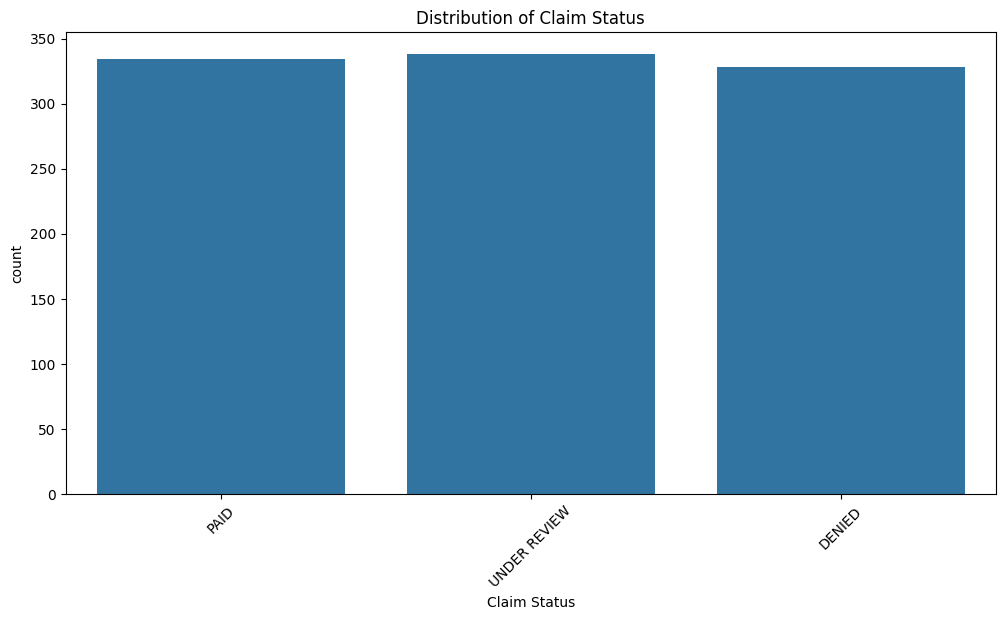

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Claim Status')
plt.title('Distribution of Claim Status')
plt.xticks(rotation=45)
plt.show()

**Key Observations:**

    The distribution is relatively balanced across all three categories.
    PAID claims total approximately 330.
    UNDER REVIEW claims are slightly higher at around 340.
    DENIED claims are just under 330.
    There's minimal variation between the categories, with all counts falling within a narrow range of approximately 325-340 claims.

This near-equal distribution suggests a consistent processing where the underlying claims are evenly spread across these statuses at the time the data was captured.

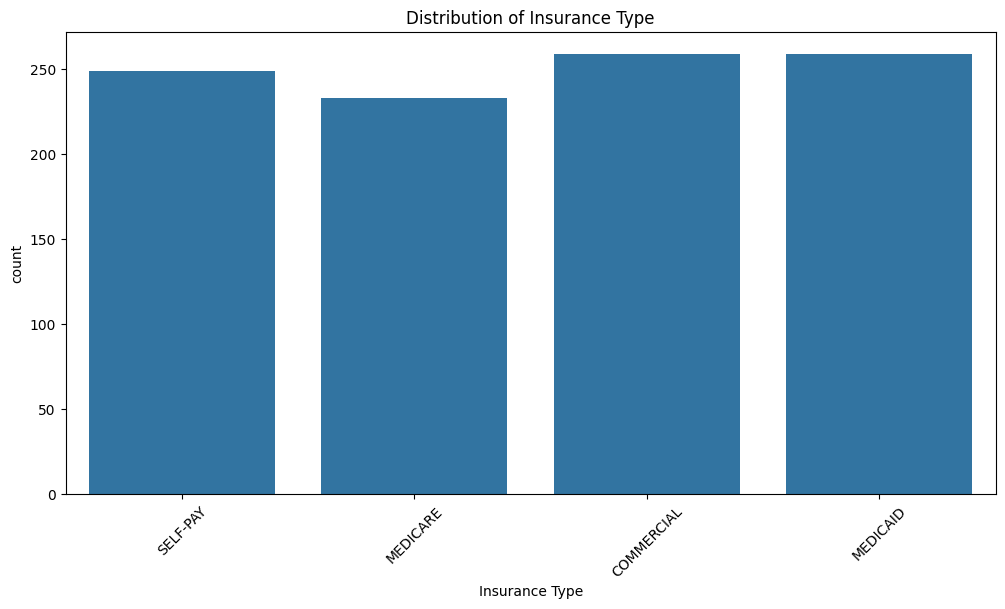

In [20]:
#Repeat for other categorical column Insurance Type
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Insurance Type')
plt.title('Distribution of Insurance Type')
plt.xticks(rotation=45)
plt.show()

Distribution of Insurance Type Description
The chart bar, the distribution of insurance types across the dataset.
Key Observations:

    COMMERCIAL and MEDICAID are the most common insurance types, each accounting for approximately 260-270 cases.
    SELF-PAY follows with around 250 cases.
    MEDICARE has the lowest count, with approximately 230 cases.
    The distribution shows a moderate variation among insurance types, with COMMERCIAL and MEDICAID being slightly more popular than the others.

This distribution suggests that the majority of claims are covered by commercial insurance or Medicaid, while Medicare represents a smaller portion of the claims processed.

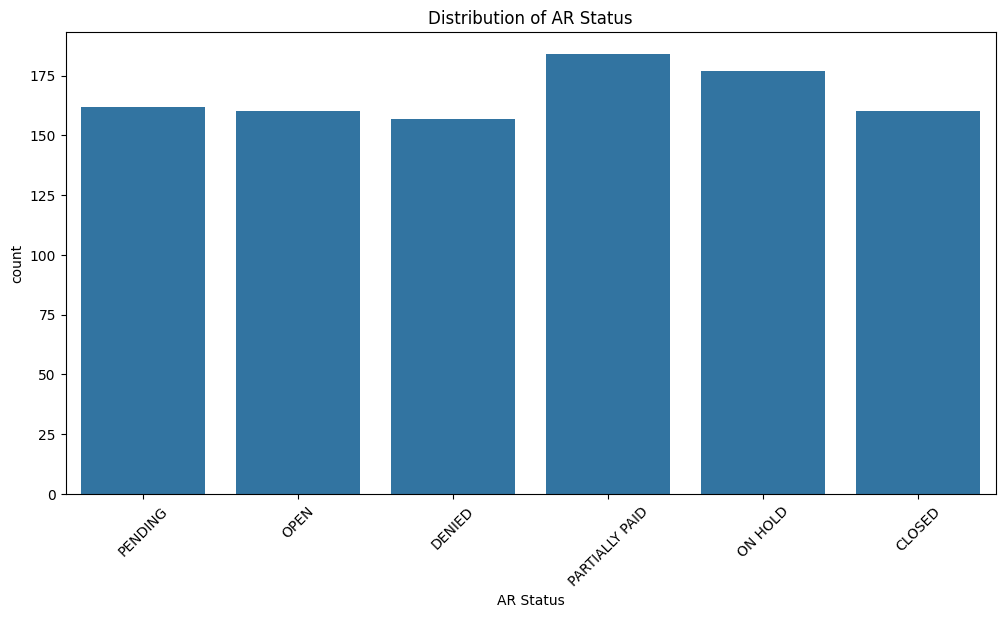

In [21]:
#Repeat for other categorical column AR Status
sns.countplot(data=df, x='AR Status')
plt.title('Distribution of AR Status')
plt.xticks(rotation=45)
plt.show()

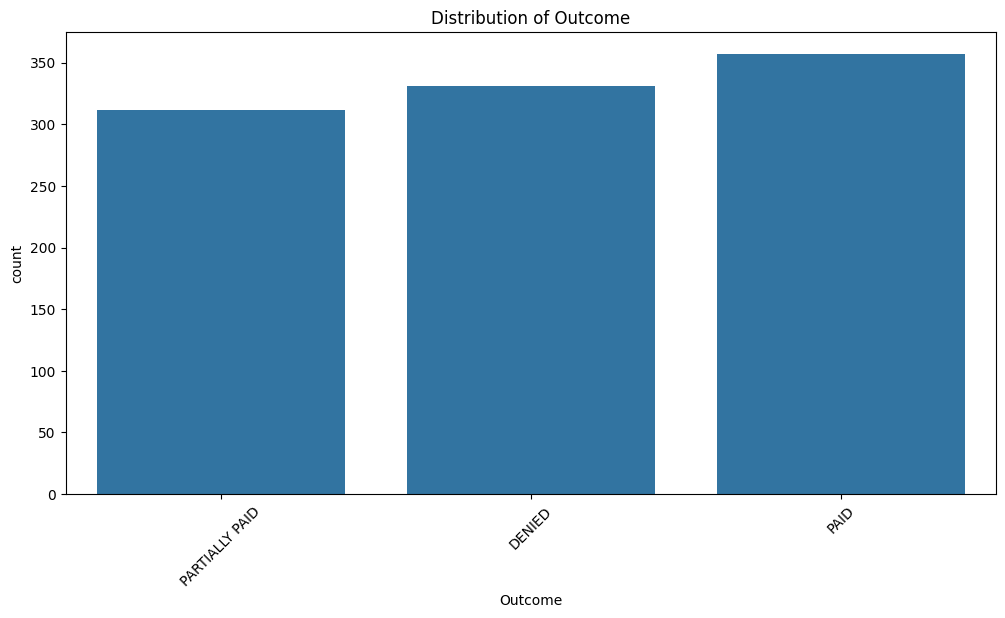

In [22]:
#Repeat for other categorical column Outcome
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Outcome')
plt.title('Distribution of Outcome')
plt.xticks(rotation=45)
plt.show()

Time-Based Analysis:

    Since we have Date of Service, analyze trends over time. For example, group by month to see billing trends:

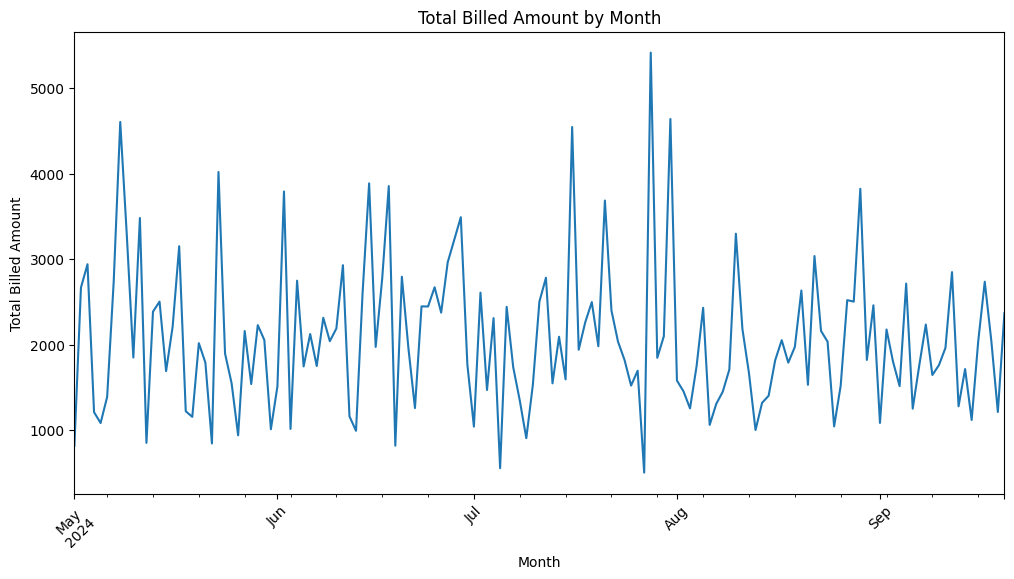

In [26]:
dfCd['Month of Service'] =pd.to_datetime(dfCd['Date of Service'])
monthly_billing = dfCd.groupby('Month of Service')['Billed Amount'].sum()

plt.figure(figsize=(12, 6))
monthly_billing.plot(kind='line')
plt.title('Total Billed Amount by Month')
plt.xlabel('Month')
plt.ylabel('Total Billed Amount')
plt.xticks(rotation=45)
plt.show()

**Key Observations:**

    The billed amounts show significant volatility throughout the period, with frequent fluctuations between approximately $1,000 and $5,500.
    Notable peaks occur in late May, mid-July, and late August, with the highest peak exceeding $5,000 in late August.
    Despite the volatility, there's no clear overall upward or downward trend in the total billed amounts over this period.
    The billed amounts appear to have a baseline fluctuation pattern with occasional sharp increases that quickly return to the baseline range.

This pattern suggests that while there are periods of significantly higher billing activity, the overall billing volume remains relatively consistent when average over time.

Cross-Tabulations:

    Explore relationships between categorical variables, such as Claim Status and Insurance Type

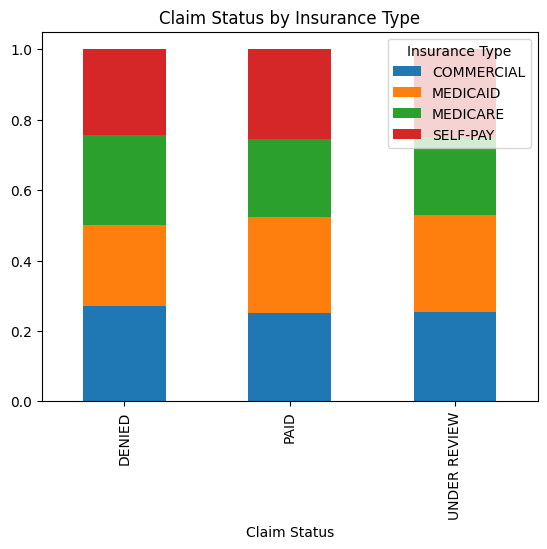

In [27]:
pd.crosstab(df['Claim Status'], df['Insurance Type'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Claim Status by Insurance Type')
plt.show()

Key Observations:
Denied Claims

    COMMERCIAL insurance accounts for approximately 30% of denied claims.
    MEDICAID represents roughly 20% of denied claims.
    MEDICARE and SELF-PAY each make up about 25% of denied claims.

Paid Claims

    SELF-PAY has the highest proportion of paid claims, representing about 30%.
    COMMERCIAL AND MEDICAID each account for approximately 25% of paid claims.
    MEDICARE makes up around 20% of paid claims.

Under review claims

    MEDICAID has the largest share of claims under review, at approximately 30%.
    COMMERCIAL follows closely with about 25%.
    MEDICARE and SELF-PAY each represent around 20-25% of claims under review.

From General Insights:

    COMMERCIAL and MEDICAID insurance types show relatively similar proportions across all claim statuses.
    SELF-PAY has a remarkable higher proportion of paid claims compared to other statuses.
    MEDICARE shows a more balanced distribution across the different claim statuses.

Correlation Analysis:

    Check for correlations between numeric fields:

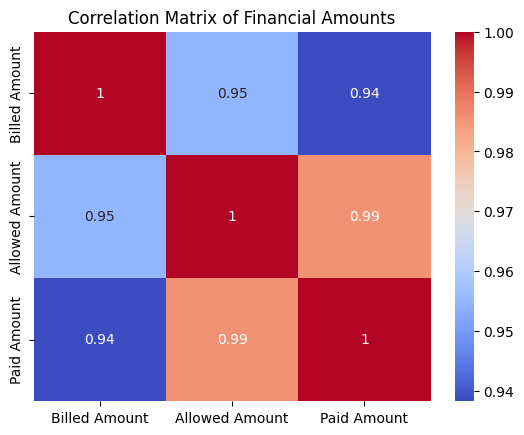

In [28]:
correlation_matrix = df[['Billed Amount', 'Allowed Amount', 'Paid Amount']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Financial Amounts')
plt.show()

Key Observations:
Strong Positive Correlations

    Billed Amount & Allowed Amount: Correlation of 0.95
    Billed Amount & Paid Amount: Correlation of 0.94
    Allowed Amount & Paid Amount: Correlation of 0.99

These values indicate very strong positive relationships between all pairs of financial amounts, with the strongest correlation being between Allowed Amount and Paid Amount.
The Interpretation

    The high correlation between Billed Amount and Allowed Amount suggests that as the amount billed increase, the allowed amount tends to increase proportionally.
    The slight lower but still very strong correlation between Billed Amount and Paid Amount indicates a similar relationship, though with slightly more more variability.
    The extremely high correlation between Allowed Amount and Paid Amount (0.99) implies that once an amount is allowed, it is very likely to be paid in full, with minimally resolved between what is allowed and what is ultimately paid.

Business Implications

    This pattern suggests efficient processing where allowed amounts are typically paid in full.
    The strong correlations may indicate consistent pricing structures or reimbursement policies.
    The relationships could be useful for financial forecasting, as knowing one amount provides a good prediction of the others.

This matrix provides valuable insight into how these financial metrics relate to each other, highlighting areas of consistency in financial processing and potential opportunities for further investigation into any that does occur

In [29]:
#Aggregate Metrics:
#Calculate key metrics, such as the percentage of claims by Claim Status:
claim_status_dist = df['Claim Status'].value_counts(normalize=True) * 100
print("Claim Status Distribution (%):")
print(claim_status_dist)

Claim Status Distribution (%):
Claim Status
UNDER REVIEW    33.8
PAID            33.4
DENIED          32.8
Name: proportion, dtype: float64


In [30]:
#Calculate average Unpaid Amount by Insurance Type:
avg_unpaid_by_insurance = df.groupby('Insurance Type')['Paid Amount'].mean()
print("\nAverage Unpaid Amount by Insurance Type:")
print(avg_unpaid_by_insurance)


Average Unpaid Amount by Insurance Type:
Insurance Type
COMMERCIAL    205.270270
MEDICAID      205.316602
MEDICARE      189.510730
SELF-PAY      201.831325
Name: Paid Amount, dtype: float64


Text(0, 0.5, 'Average Unpaid Amount')

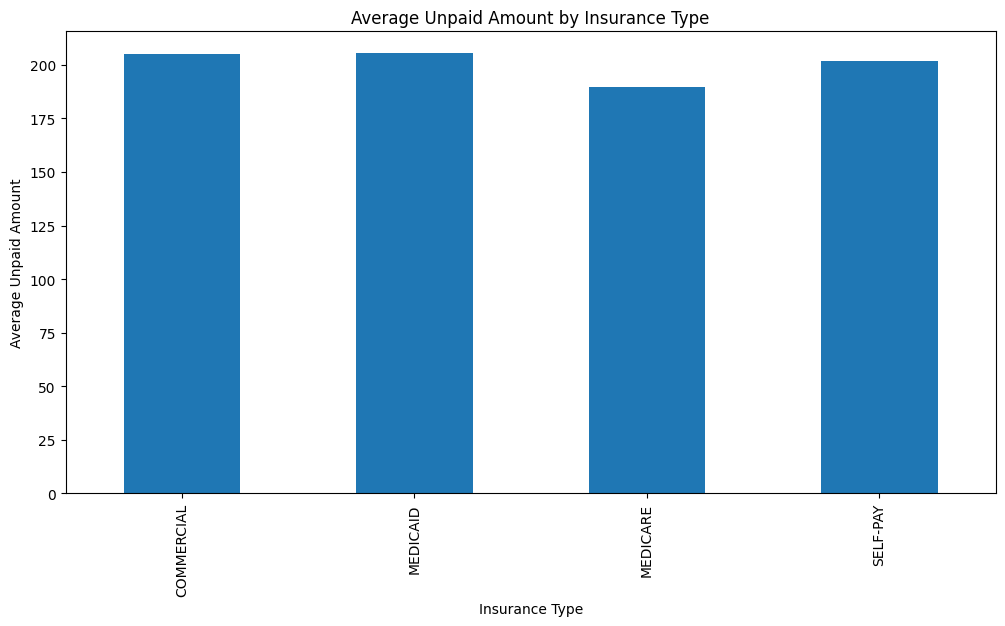

In [33]:
#Create a bar chart for unpaid amounts by Insurance Type:
plt.figure(figsize=(12, 6))
avg_unpaid_by_insurance.plot(kind='bar')
plt.title('Average Unpaid Amount by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Average Unpaid Amount')

In [34]:
#Export the data to a format compatible with tools like Tableau or Power BI for interactive dashboards
dfCd.to_csv('cleaned_claims_data_tableau.csv', index=False)


In [35]:
dfCd.to_csv('for_dashboard.csv', index=False)
from google.colab import files
files.download('for_dashboard.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>